In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_excel('Dataset/Default.xlsx')

print("Setup Complete.")

C:\Users\EZE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Setup Complete.


In [2]:
# Print the column names to identify the correct target column name
print(df.columns)

Index(['Unnamed: 0', 'default', 'student', 'balance', 'income'], dtype='object')


In [3]:
# Get information about the dataset
print(df.info())

# Get the shape of the dataset
print(df.shape)

# Get summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB
None
(10000, 5)
        Unnamed: 0       balance        income
count  10000.00000  10000.000000  10000.000000
mean    5000.50000    835.374886  33516.981876
std     2886.89568    483.714985  13336.639563
min        1.00000      0.000000    771.967729
25%     2500.75000    481.731105  21340.462903
50%     5000.50000    823.636973  34552.644802
75%     7500.25000   1166.308386  43807.729272
max    10000.00000   2654.322576  73554.233495


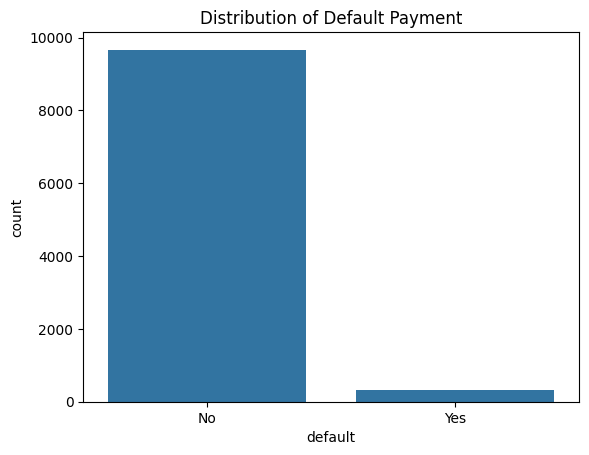

In [4]:

# Visualize the distribution of the target variable
sns.countplot(x='default', data=df)
plt.title('Distribution of Default Payment')
plt.show()

In [5]:

# Drop the unnecessary index column
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Convert categorical columns to numeric
# Assuming 'default' and 'student' contain 'Yes'/'No' values
if df['default'].dtype == 'object':
    df['default'] = df['default'].apply(lambda x: 1 if x == 'Yes' else 0)
if 'student' in df.columns and df['student'].dtype == 'object':
    df = pd.get_dummies(df, columns=['student'], drop_first=True)

# Separate features and target
X = df.drop('default', axis=1)
y = df['default']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale all features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
print('Original training shape:', X_train.shape)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Resampled training shape:', X_train_res.shape)
print('Class distribution after SMOTE:', np.bincount(y_train_res))

Original training shape: (8000, 3)
Resampled training shape: (15468, 3)
Class distribution after SMOTE: [7734 7734]


In [7]:
# Train Random Forest on Resampled Data
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_resampled.fit(X_train_res, y_train_res)

# 1. Default Evaluation (0.5 Threshold)
y_pred_default = rf_resampled.predict(X_test)
print('--- Random Forest with SMOTE (Default Threshold 0.5) ---')
print(classification_report(y_test, y_pred_default))

# 2. Threshold Tuning (catching more fraud)
y_probs = rf_resampled.predict_proba(X_test)[:, 1]
threshold = 0.3  # Lowering threshold from 0.5 to 0.3
y_pred_tuned = (y_probs >= threshold).astype(int)

print(f'--- Random Forest with SMOTE (Tuned Threshold {threshold}) ---')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix (Tuned):')
print(confusion_matrix(y_test, y_pred_tuned))

--- Random Forest with SMOTE (Default Threshold 0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1933
           1       0.22      0.73      0.34        67

    accuracy                           0.90      2000
   macro avg       0.61      0.82      0.64      2000
weighted avg       0.96      0.90      0.93      2000

--- Random Forest with SMOTE (Tuned Threshold 0.3) ---
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1933
           1       0.17      0.82      0.29        67

    accuracy                           0.86      2000
   macro avg       0.58      0.84      0.61      2000
weighted avg       0.97      0.86      0.90      2000

Confusion Matrix (Tuned):
[[1672  261]
 [  12   55]]


In [8]:

# Create a logistic regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [9]:

# Create a Random Forest model with balanced class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Print the classification report
print('--- Random Forest Model ---')
print(classification_report(y_test, y_pred_rf))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_rf))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')

--- Random Forest Model ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1933
           1       0.60      0.31      0.41        67

    accuracy                           0.97      2000
   macro avg       0.79      0.65      0.70      2000
weighted avg       0.96      0.97      0.97      2000

[[1919   14]
 [  46   21]]
Accuracy: 0.97


In [13]:

# Create a logistic regression model with balanced class weights
lr_model_balanced = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model
lr_model_balanced.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr_balanced = lr_model_balanced.predict(X_test)

# Print the classification report
print('--- Logistic Regression (Balanced Weights) Model ---')
print(classification_report(y_test, y_pred_lr_balanced))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_lr_balanced))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr_balanced)}')

--- Logistic Regression (Balanced Weights) Model ---
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1933
           1       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000

[[1651  282]
 [   8   59]]
Accuracy: 0.855


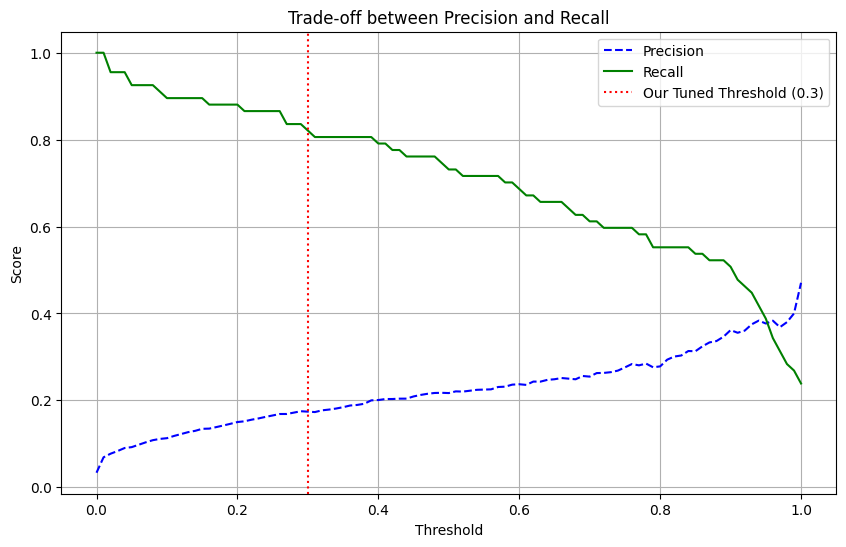

This chart shows that as we LOWER the threshold (moving left),
the Recall (Green) goes UP, meaning we catch more fraud!


In [11]:
# Visualize the Trade-off between Precision and Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Trade-off between Precision and Recall')
plt.axvline(x=0.3, color='r', linestyle=':', label='Our Tuned Threshold (0.3)')
plt.legend()
plt.grid(True)
plt.show()

print('This chart shows that as we LOWER the threshold (moving left),')
print('the Recall (Green) goes UP, meaning we catch more fraud!')

In [14]:
# FINAL EVALUATION (Using Optimized Model & Tuned Threshold)
print('--- FINAL OPTIMIZED MODEL PERFORMANCE ---')
print(f'Using Threshold: {threshold}')
print(classification_report(y_test, y_pred_tuned))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_tuned))

final_acc = accuracy_score(y_test, y_pred_tuned)
print(f'Final Accuracy: {final_acc:.3f}')

--- FINAL OPTIMIZED MODEL PERFORMANCE ---
Using Threshold: 0.3
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1933
           1       0.17      0.82      0.29        67

    accuracy                           0.86      2000
   macro avg       0.58      0.84      0.61      2000
weighted avg       0.97      0.86      0.90      2000

Confusion Matrix:
[[1672  261]
 [  12   55]]
Final Accuracy: 0.864
